In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

primary = pd.read_csv('../clean-datasets/primary.csv')
primary_with_revenue = pd.read_csv('../clean-datasets/primary-with-revenue.csv')
primary_with_valuation = pd.read_csv('../clean-datasets/primary-with-valuation.csv')

In [4]:
primary.head()

,name,tagline,summary,description,year_founded,website,city,region,country,postal_code,...,keywords,investor_count,mosaic_change,funding_total_millions,last_funding_millions,funding_count,last_funding_type,last_funding_date,sentiment,articles
0,Valera Health,"Your Path to Wellness, Just a Click Away","Valera Health, based in New York, is a mental ...",Valera Health operates as a tele-mental health...,2015.0,https://valerahealth.com,Brooklyn,New York,United States,11249,...,"['Mental Health Care', 'Telemedicine', 'Health...",20,-117.0,76.32,9.12,8,Series B - II,2024-04-09,"{'sentimentScore': 100, 'cntPositive': 15, 'cn...",[{'contentId': 'ab325015a7bbae7beefc4833b73696...
1,Bestow,"Protecting Life, Simplified",Bestow is a Texas-based company that offers fa...,Bestow operates as an insurance technology com...,2017.0,https://bestow.com,Dallas,Texas,United States,75226,...,"['Insurance', 'Technology', 'Healthcare', 'Fin...",8,-119.0,138.10,70.00,5,Series C,2020-12-16,"{'sentimentScore': 90, 'cntPositive': 48, 'cnt...",[{'contentId': 'b633176d-6378-46d0-9b15-d2b611...
2,PlainID,"Secure Your Identity, Empower Your Business",PlainID is a company based in Tel Aviv that sp...,PlainID is an Identity Security Posture Manage...,2014.0,https://plainid.com,Tel Aviv,NaN,Israel,6789139,...,"['Cybersecurity', 'Identity Management', 'Data...",10,-120.0,99.00,75.00,5,Series C,2021-12-21,"{'sentimentScore': 100, 'cntPositive': 21, 'cn...",[{'contentId': '29c3c127-069d-4be7-aaf6-3a89bb...
3,Snapcart,"Innovating Connections, Empowering Insights",Snapcart is a commercial company based in Jaka...,Snapcart specializes in real-time offline shop...,2015.0,https://snapcart.global,Jakarta,NaN,Indonesia,12940,...,"['Artificial Intelligence & Machine Learning',...",9,124.0,14.70,10.00,4,Series A,2017-10-25,"{'sentimentScore': 92, 'cntPositive': 7, 'cntN...",[{'contentId': '5ffd28ae-d4f3-46e2-a3b1-526c96...
4,slice,"Experience Money, Mastered.",slice is a financial technology company based ...,Slice operates as a financial technology compa...,2016.0,https://sliceit.com,NaN,Assam,India,781028,...,"['FinTech', 'ConsumerTech', 'E-Commerce', 'Dig...",36,-76.0,390.50,7.77,21,Debt - VIII,2024-07-19,"{'sentimentScore': 89, 'cntPositive': 36, 'cnt...",[{'contentId': 'ce75fa10-6d0f-45d5-bf66-2532b8...


In [5]:
primary.shape

(5509, 21)

In [33]:
primary.isnull().sum()

name                         0
tagline                      0
summary                      0
description                  0
year_founded                 0
website                      0
city                       328
region                    1401
country                      0
postal_code                369
concepts                     0
keywords                     0
investor_count               0
mosaic_change                0
funding_total_millions       0
last_funding_millions        0
funding_count                0
last_funding_type            0
last_funding_date            0
sentiment                    0
articles                     0
dtype: int64

# Mosaic change vs date of most recent funding

The mosaic score for a company is an internal metric designed by CB Insights (https://www.cbinsights.com/) for evaluating the long-term success of startups. Without a paid account, only the mosaic score change was available to scrape for each startup. This plot puts startups into bins based on their most recent funding date, then creates a violin plot for each bin to show the distribution of its mosaic score changes. 

From this plot, we can see that startups that have recently received funding tend to have more positive mosaic score changes. This intuitively makes sense: if a startup has not been funded for a long time, it is less likely to be a long-term success.

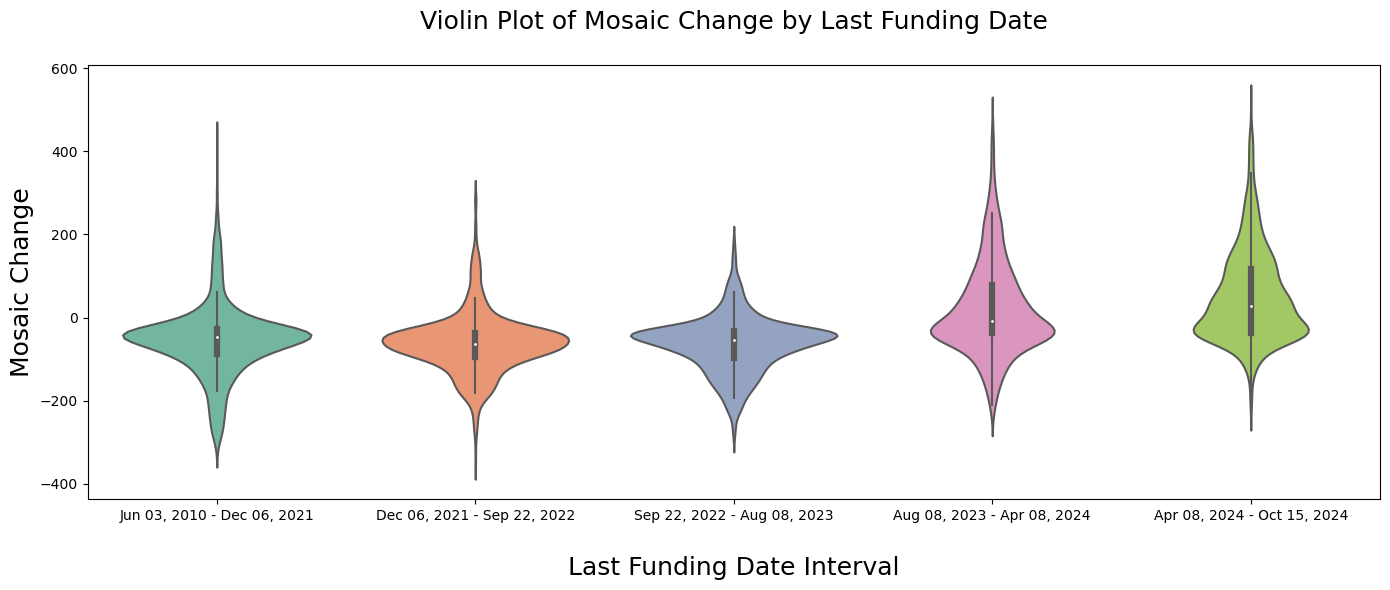

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def ordinal_date_to_string(date):
    return pd.Timestamp.fromordinal(int(date)).strftime("%b %d, %Y")

# Copy columns from primary 
df = primary[['last_funding_date', 'mosaic_change']].copy()

# Convert last_funding_date to datetime type
df['last_funding_date'] = pd.to_datetime(df['last_funding_date'])

# Convert datetime last_funding_date to ordinal type
df['last_funding_date_ordinal'] = df['last_funding_date'].map(pd.Timestamp.toordinal)

# Split into n_bins bins based on qcut (by quantile)
n_bins = 5
df['last_funding_date_bin'], bins = pd.qcut(df['last_funding_date_ordinal'], q=n_bins, retbins=True)

# Labels for the n_bins bins
bin_labels = [f'{ordinal_date_to_string(bins[i])} - {ordinal_date_to_string(bins[i+1])}' for i in range(len(bins)-1)]
df['last_funding_date_bin'] = pd.qcut(df['last_funding_date_ordinal'], q=n_bins, labels=bin_labels)

# Violin plots
plt.figure(figsize=(14, 6))
sns.violinplot(x='last_funding_date_bin', y='mosaic_change', data=df, palette='Set2')
plt.title('Violin Plot of Mosaic Change by Last Funding Date\n', fontsize=18)
plt.xlabel('\nLast Funding Date Interval', fontsize=18)
plt.ylabel('Mosaic Change', fontsize=18)
plt.tight_layout()
plt.show()


# Most common words in startup descriptions

Each of the startups in our dataset has a description written by CB Insights. Using these descriptions, we can extract the most common words and create a frequency plot. Some of the descriptions contain city names, so we are getting common city names and removing them from the descriptions before processing the words. We are also moving stopping words like 'the', 'and', and 'but'. 

From this frequency plot, we can get an idea of what types of companies we are looking at, and what the most popular areas are.

Getting city set to remove city names from common words.

In [57]:
import requests

def get_city_set():
    response = requests.get('https://raw.githubusercontent.com/FinNLP/cities-list/refs/heads/master/list.txt')
    if response:
        cities = response.text.splitlines()
        return {city.strip().lower() for city in cities}
    
print(list(get_city_set())[:5])

city_set = get_city_set()

['saint-cere', 'ourem', 'ontario', 'umea', 'fred']


Using Counter to count frequency of words. Removing stop words like "and", "but", "now", and filler words like "provides","including", and "various".

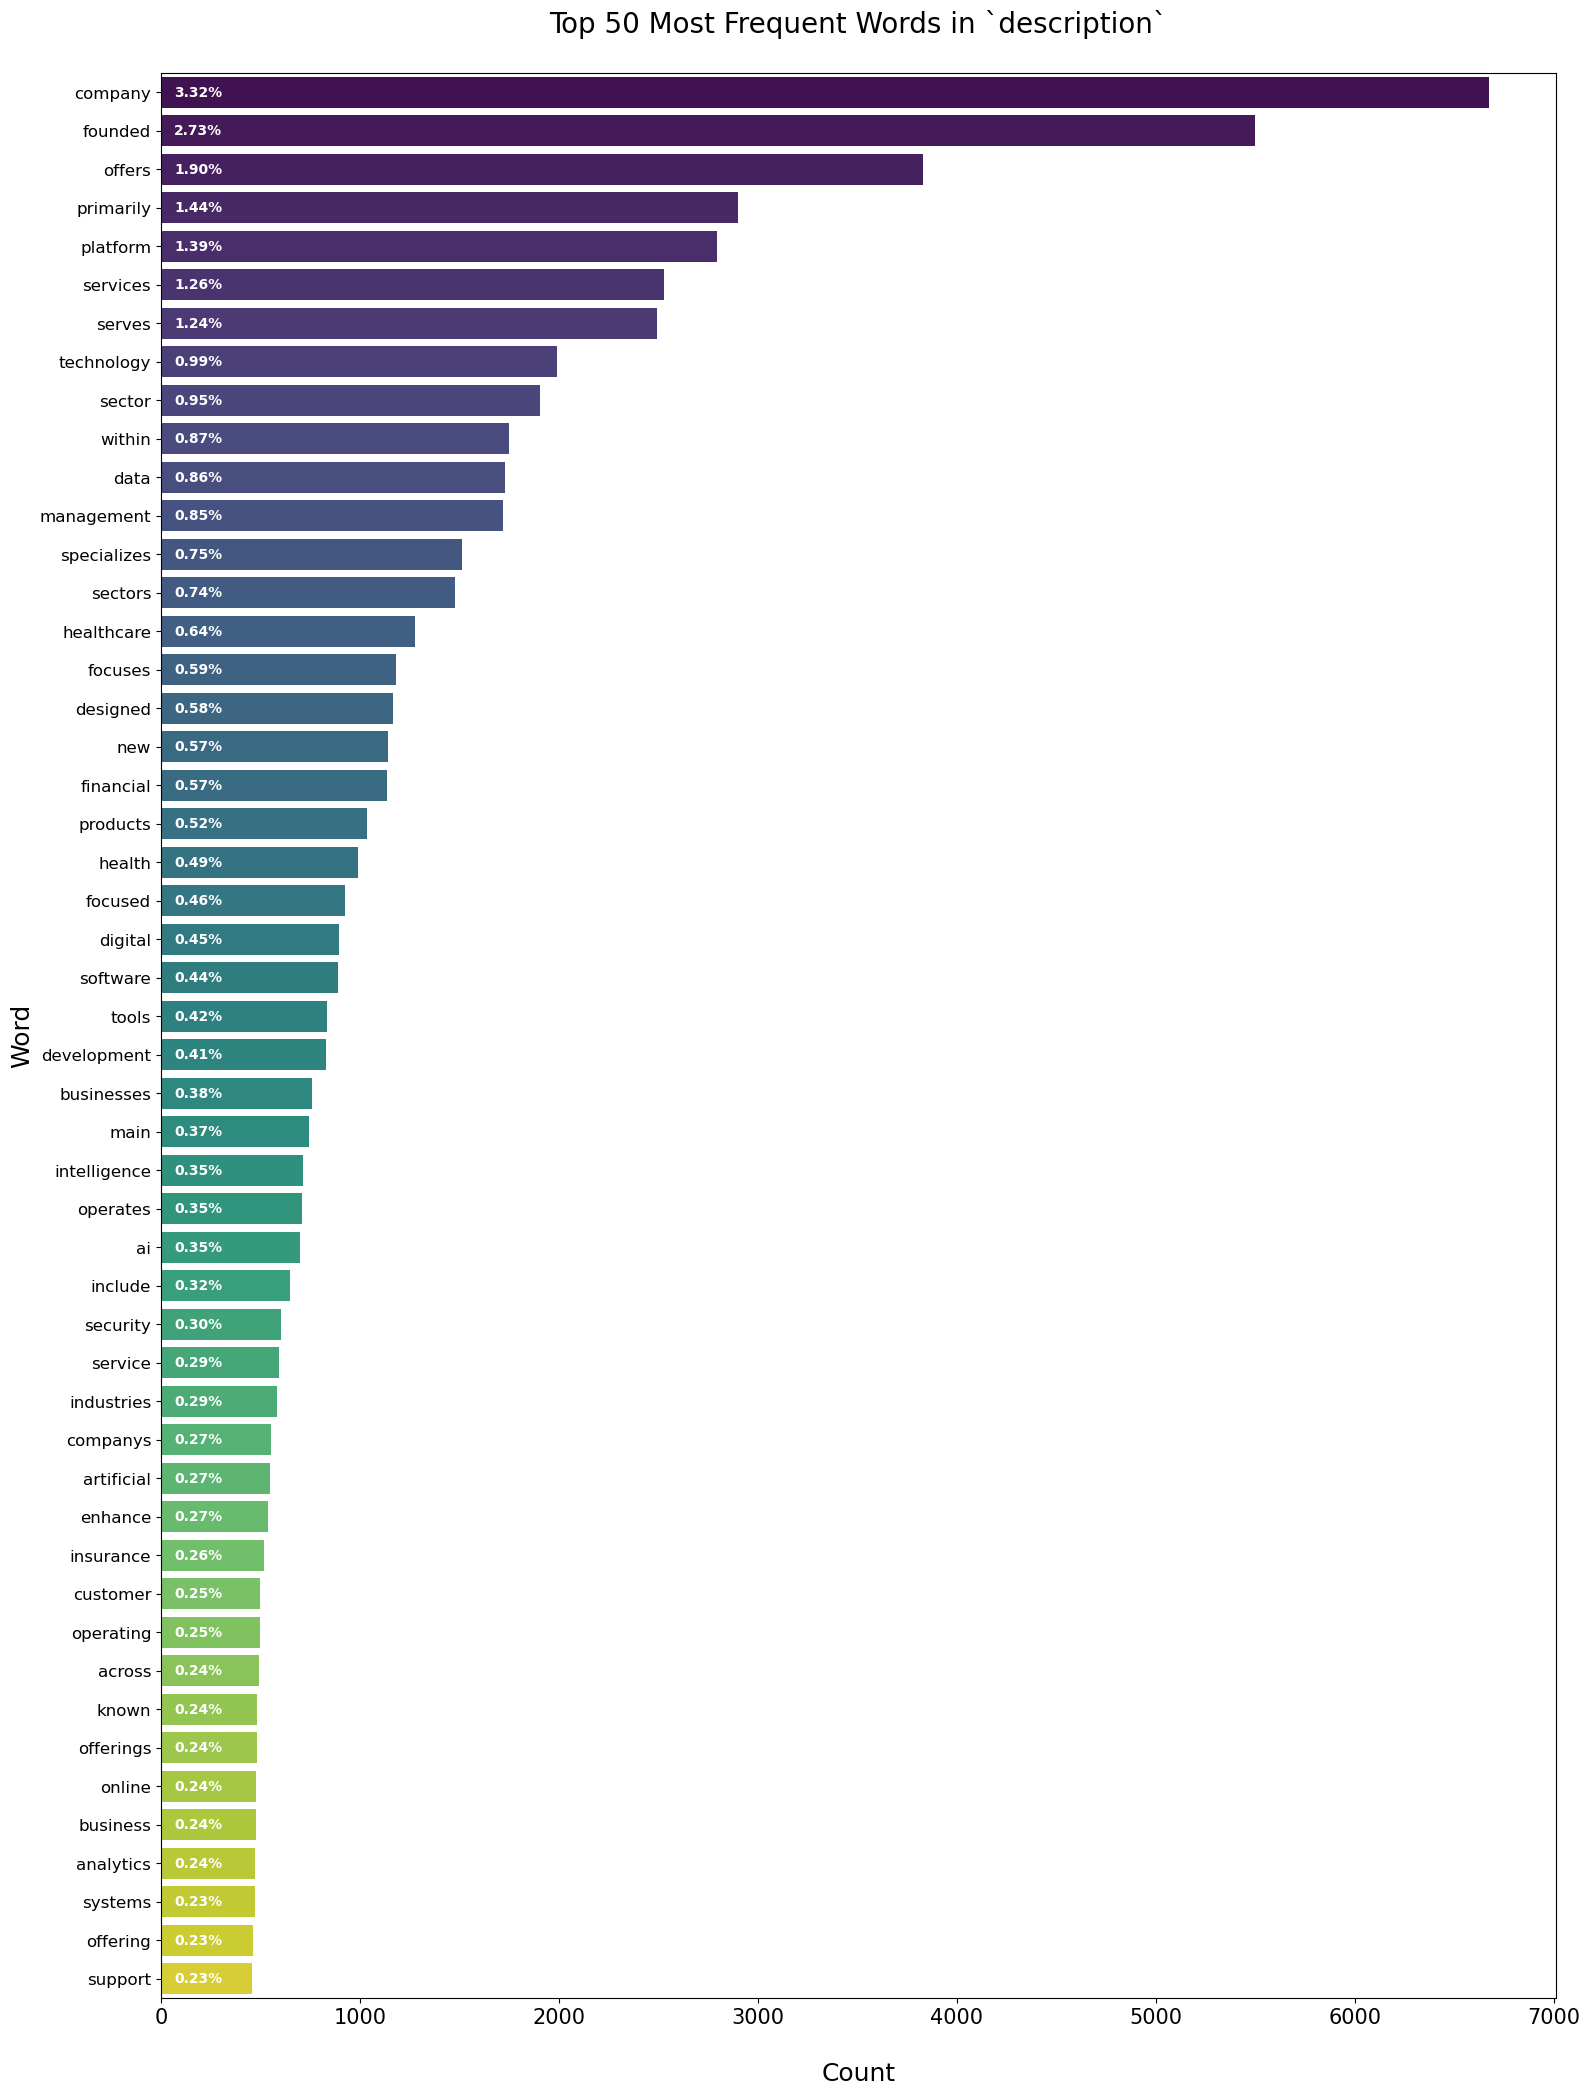

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import requests
import re

response = requests.get("https://gist.githubusercontent.com/sebleier/554280/raw/7e0e4a1ce04c2bb7bd41089c9821dbcf6d0c786c/NLTK's%2520list%2520of%2520english%2520stopwords")
stop_words = response.content.decode('utf-8').split('\n')[:-1]

# Block additional words
stop_words.extend(['various','including','provides','providing','based','real','tomorrows','delivering','mastering','securely','made','igniting','uniting','crafting','minds','ignite','bridging','vision','accelerate','unveiling','delivered','connection','step','also','like','one','time','-','unleashing','unleash','future','potential','revolutionizing','success','transforming','power','elevate','elevating','unlocking','care','simplifying','precision','world','effortlessly','innovation','empowering','connecting','securing','experience','simplified','powering','solutions','insights','growth','accelerating','confidence','savor','home','futures','possibilities','tomorrow','journey','innovating','shaping','master','drive','beyond','driving','unlock','every','click','transform','navigating','redefining','discover','empower'])

def clean(text):
    # Make lowercase and remove non-alphabetical words
    text = re.sub(r'[^a-z\s-]', '', text.lower())
    
    # Tokenize
    tokens = text.split()
    
    # Remove non-meaningful words (and,the,but,now...)
    return [word for word in tokens if word not in stop_words and word not in city_set]

def get_counts(text_series):
    # Combine sentences
    combined_text = ' '.join(text_series)
    
    # Clean and tokenize the combined text
    cleaned_words = clean(combined_text)
    
    # Word count
    return Counter(cleaned_words)

# Top N words
def top(counts, N):
    total_words = sum(counts.values())
    return [(word, count, (count / total_words) * 100) for word, count in counts.most_common(N)]

# Plot
def plot_word_freq(words, N, column):
    word_freq_df = pd.DataFrame(words, columns=['Word', 'Count', 'Freq'])
    max_count = word_freq_df['Count'].max()
    
    plt.figure(figsize=(18, 25))

    # Counts
    sns.barplot(y='Word', x='Count', data=word_freq_df, palette='viridis')
    
    # Frequencies
    for word, row in word_freq_df.iterrows():
        plt.text(0.01*max_count, word, f"{row['Freq']:.2f}%", color='white', ha='left', va='center', fontweight='bold')

    plt.title(f'Top {N} Most Frequent Words in `{column}`\n', fontsize=20)
    plt.xlabel('\nCount', fontsize=18)
    plt.ylabel('Word', fontsize=18)
    plt.xticks(fontsize = 15) 
    plt.yticks(fontsize = 12) 
    #plt.savefig(f'../visualizations/top-{N}-frequent-in-{column}.png')
    plt.show()
    
def main():
    df = primary[['description']].copy()
    
    column = 'description'

    df_concepts = df[column]
    df_concepts = df_concepts.str.replace(r'[\[\]]', '', regex=True)
    
    N = 50
    freq = False
    
    word_counts = get_counts(df_concepts)
    top_words = top(word_counts, N)
    
    plot_word_freq(top_words, N, column)
    
if __name__ == '__main__':
    main()

# Number of startups by country

We have the country information for each of our startups, so we can plot a map showing how many startups are in each country in our dataset. From this plot, we get an idea of where the startups we are analyzing are located, and we can also decide if there are countries we want to drop or countries we want to gather more data for. 

In [98]:
df = primary[['country']].copy()

# Count number of rows with same countries
df2 = primary['country'].value_counts().reset_index()
df2.columns = ['country', 'startup_count']
df2['log_startup_count'] = np.log(df2['startup_count'])
df2.head()

,country,startup_count,log_startup_count
0,United States,3148,8.054523
1,United Kingdom,422,6.045005
2,Israel,242,5.488938
3,India,200,5.298317
4,France,191,5.252273


Using `plotly`'s choropleth function to generate a location plot. 

In [114]:
import plotly.express as px

fig = px.choropleth(
    df2, 
    locations="country",
    locationmode='country names',
    color="log_startup_count",  
    color_continuous_scale="PuBu",  
    title="Startups by country in our dataset",
    labels={'log_startup_count': 'ln(startups by country)'}
)

# Remove exterior box and ocean edges
fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=False
    )
)

fig.show()
